We import `read_dat` and it handles most things we need. If we need more, we can import them ourselves.

In [1]:
from read_dat import *

file = read_dat(r'STNG.dat')

init complete


This creates a `read_dat` object, which is the basis for everything that follows. The object is the access to the data file that gets loaded when we call `read_dat` above.

The filename is the only required argument, but there are many options available to us:

```Python
read_dat(file_name, sample_rate, CFD, t_start, t_long, t_short, baseline_samples)
```

| Parameter	| Type	| Details	| Default   |
|---    |---    |---    |---    |
| `file_name` | str   | Must include file suffix “.dat”   | n/a   |
| `sample_rate`   | float | ns per sample for the acquired data | 2 (DT5730 sample rate)  |
| `CFD`   | array float | 1D array of length 3. [Fraction, Length (samples), Offset (samples)]. Refer to `event.CFD` for more information on what these parameters are | [0.75, 6, 6]  |
| `t_start`   | array float | Start time (ns) from the CFD defined t_0    | [-80] |
| `t_long`    | array float | Long integral gate (ns) from the CFD defined t0   | [400]   |
| `t_short`   | array float | Short integral gate (ns) from the CFD defined t0  | [10]  |
| `baseline_samples`  | int   | Length of baseline calculation in samples | 200   |



There are 5 public methods for the `read_dat` object:

| Method    | What it does  |
|---    |---    |
| `read_event`    | Reads the events stored in `file_name` one at a time, in order    |
| `lst_out`   | Reads multiple events, or the whole file, with list mode output options. Produces a `params` or `trace` csv file per channel if requested |
| `get_fails` | Returns fail information for the processed events |
| `add_selections`    | Used to add multiple cuts to the events. Can be done manually, clicking on a 2D histogram, or simply through the input of a file of coordinates   |
| `select_events` | Pulls all the events that fall within the specified area. Works only after running `add_selections`, otherwise all events will be returned  |

## `read_event`
This reads the next event in the file, starting from the beginning, and returns an array containing `event` objects, one for each channel that was set active. In this case, we only have 2 active channels: the anode and the dynode. If the end of the file is reached, `read_event()` returns `True`.

If this method is called again, the next event in the file will be read out. There is currently no way to read an event with a specific event id but I hope to make this available in the future.

In [2]:
ev = file.read_event()
print(ev)

[<event.event object at 0x7fb3f0664340>, <event.event object at 0x7fb3f4eb3160>]


The events aren't in a format that we can interpret so we can extract the meaningful information in a few ways.

We can first just get the voltage traces as is, if we want to analyse them ourselves. 

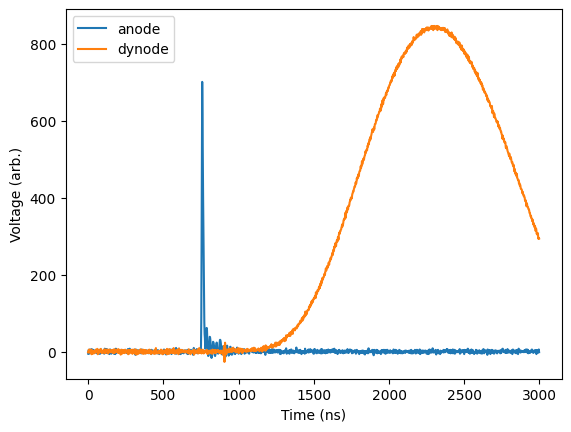

In [3]:
anode_trace = ev[0].get_trace()
dynode_trace = ev[1].get_trace()

time = np.arange(len(anode_trace))*2

plt.plot(time, anode_trace, label='anode')
plt.plot(time, dynode_trace, label='dynode')
plt.xlabel('Time (ns)')
plt.ylabel('Voltage (arb.)')
plt.legend()

See the `event` tutorial for more about how to play with events. For now we move on to the next method.

## `lst_out`
```Python
lst_out(events, ch, output, traces, cuts, filename)
```

| Parameter | Type  | Details | Default |
|---    |---    |---    |---    |
| `events`  | int or bool   | The number of events to read and output the desired list mode information. If `False` the full file is read.| `False` |
| `ch`  | array int or bool | If `True` all channels are read out. If int array, only the selected channels are read out (channel numbering from 0) | `True`    |
| `output`  | array int or bool | If `True` L [ch], S [ch], T_trigger [us], baseline [bits], pulse height [bits] are read out into a file per channel. If a binary int array (len=5) only the selected parameters are read out. The format of the array is [L, S, T, baseline, PH] where 1 is an indication to output that parameter and 0 is to ignore that parameter  | `True`    |
| `traces`  | bool  | If `True`, traces will be output in list mode in a csv file per channel. Otherwise traces will not be output  | `False`   |
| `cuts`    | array int or bool | If `False`, no cuts are applied to output. If an int array (len = number of cuts added) where the index of the array is the cut id and the value being 1, 0 or -1 includes, ignores or excludes that cut  | `False`   |
| `filename`    | str   | Desired output file name. If left empty, it uses the `file_name` of the original file    | ""    |

This method outputs csv files containing data from each event, in list mode. Files will be named [*filename*]\_params\_[*ch*].csv and [*filename*]\_trace\_[*ch*].csv. Each channel will have its own pair of files.

Below we get run it on the anode pulse for the first 100 events, getting traces out as well as the default parameters.

In [4]:
file.lst_out(100, [0], traces=True)

End reading


I don't really know much about how this works, but one useful thing is that it can be used after selections have been made, which we will show later on.

## get_fails
```Python
get_fails(display)
```

I don't know what this does so I won't try to explain it. It takes one argument, `display`, which when `False` means it won't display anything to terminal. Default is `False`.

It returns an `n x 5`D array of ints, for `n` channels, in the format of [start, long, short, integral, zero]. The value at the associated index indicates the number of fails out of the processed events that have failed that check.

| Index | Fail Name | Fail Condition    |
|---    |---    |---    |
| 0 | start | The start time is set outside of the acquisition window   |
| 1 | long  | The long integral end gate is outside of the acquisition window   |
| 2 | short | The short integral end gate is outside of the acquisition window  |
| 3 | integral  | The calculated short integral is negative or the calculated long integral has a smaller value than the calculated short integral  |
| 4 | zero  | The CFD calculation failed to return a reasonable t0  |

It also returns an array of `n` ints, saying how many fails per channel. Finally an event counter, for how many events were processed.

In [5]:
file.get_fails(display=True)

Channel: 0	Events: 101	Fails: 0.0
tstart: 0.0	tlong: 0.0	tshort: 0.0	integral: 0.0	t0: 0.0
Channel: 1	Events: 101	Fails: 1.0
tstart: 1.0	tlong: 0.0	tshort: 0.0	integral: 0.0	t0: 0.0


(array([[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([0., 1., 0., 0., 0., 0., 0., 0.]),
 101)

## add_selections
```Python
add_selections(L, S, mode, lims, file)
```

Method to add multiple cuts to the events. Can be run in manual `m` or predetermined `p` modes. 

| Parameter | Type | Details | Default |
|---    |---    |---    |---    |
| `L`   | array float   | Array of `L` values for the processed events  | []    |
| `S`   | array float   | Array of `S` values for the processed events  | []    |
| `mode`    | char  | `m`: Manual mode, `p`: predetermined mode | `m`   |
| `lims`    | 2x2 array float   | Array of x and y limits for the visual aid SL plot    | [[0, 50000], [0, 1]]  |
| `file`    | `False` or str    | See explanation below | `False`   |

I don't fully understand why this method works in the way that it does, but I'm too scared to try and improve it so the best I can do is explain how I think it should be used.

There are two modes of operation: manual `m` and predetermined `p`. 

Manual mode allows the user to input arrays of `L` and `S` values so that cuts can be made to separate the neutron and gamma events. This is done by clicking on points on a 2D histogram, defining a polygon that encloses the events of interest. In manual mode, these arrays **need** to be supplied or else it won't work. Once the cuts have been made, they get saved to the `read_dat` object and are used by the `select_events` method later on. 

By default, no file containing the coordinates of the selections is output when in manual mode. A key needs to be pressed (more on this later) and then they get output to a file named "`file_name`\_cuts\_SL.csv". That is the `file_name` that was used to instantiate the `read_dat` object. If the predetermined mode is being used, this step needs to happen first so that it has an input file to work with.

In predetermined mode, no arrays of `L` and `S` need to be supplied, and no display is shown for selections to be made. This mode simply takes the selections in the input file and loads them into the `read_dat` object. Here a `file` **needs** to be supplied.

### Making selections in manual mode

When in manual mode, we can make selections on the 2D histogram. There are a number of keys that can be pressed to activate certain commands.

| Key&nbsp;&nbsp; | Action    |
|---    |---    |
| a, A  | Add a new selection   |
| u, U  | Undo previous point, only usable while in a selection |
| x, X  | End current selection, can only end a selection if there are more than 2 co-ordinates in the selection    |
| d, D  | Delete previous completed selection   |
| o, O  | Output the selections added to the file "`file_name`\_cuts\_SL.csv"  |
| q, Q  | Quit, ends visual guide and re-enters the main code segment   |

Once a has been pressed, use the left mouse click to select co-ordinates. The co-ordinates will be printed to the screen as well as saved. 

In [6]:
L=[[],[]]
S=[[],[]]
for i in range(500):#read 500 events
	event = file.read_event()
	for j in range(len(event)): #per channel
		S[j].append(event[j].get_pulse_shape())
		L[j].append(event[j].get_long_integral())

/home/mkidson/gitRepos/dDAQ_dev/dDAQ_final/event.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return self.shortIntegral/self.longIntegral


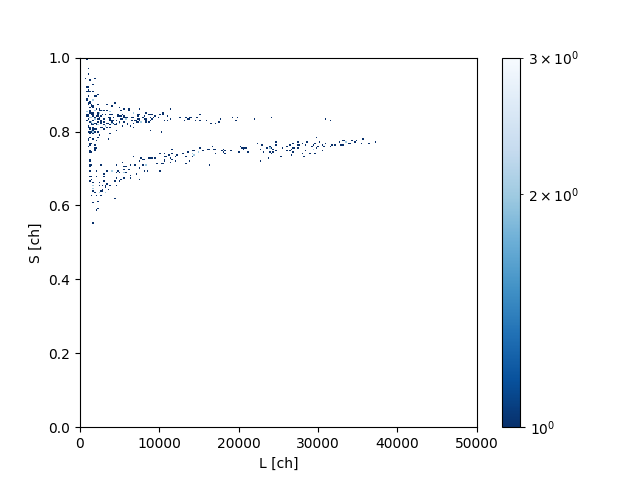

Begin selection for cut 1
1386.0887096774186 0.5308441558441559
8316.532258064512 0.6417748917748918
36542.3387096774 0.722943722943723
38810.48387096773 0.7635281385281386
38810.48387096773 0.7905844155844156
8064.516129032254 0.7581168831168832
630.0403225806458 0.676948051948052
End selection
Begin selection for cut 2
1386.0887096774186 0.6931818181818182
8442.54032258064 0.7851731601731602
33014.112903225796 0.8176406926406927
33014.112903225796 0.8474025974025975
6300.403225806449 0.8961038961038962
882.0564516129034 0.9853896103896104
504.032258064517 0.9664502164502166
504.032258064517 0.7012987012987013
End selection
Selections outputted to file: STNG_cuts_SL.csv


No such comm: b6e7157c902943ad826d9f38ee78d742
No such comm: b6e7157c902943ad826d9f38ee78d742
No such comm: b6e7157c902943ad826d9f38ee78d742
No such comm: b6e7157c902943ad826d9f38ee78d742


In [7]:
%matplotlib widget
file.add_selections(L=L[0],S=S[0],mode="m")

As you can see, we made two cuts and saved them to a file so we can use them again later. I decided to use this interactive inline matplotlib package that seems to work ok. It requires the package `ipympl` to be installed (`pip install ipympl`). If it's giving you problems, just restart the jupyter kernel and change it from `widget` to `tk`. That will make the plot pop out instead of being inline but it works really well otherwise. If you're not using a jupyter notebook then the default matplotlib settings will work fine.

## `select_events`

With the cuts made, we can start to actually separate events using this method. `add_selections` appends the cuts created to an internal variable of the `read_dat` class, which this method accesses. 

```Python
select_events(L, S, cut_id, inc, visual, lims)
```
| Parameter | Type | Details | Default |
|---    |---    |---    |---    |
| `L`   | array float   | Array of `L` values for the processed events  | n/a   |
| `S`   | array float   | Array of `S` values for the processed events  | n/a   |
| `cut_id`  | array int | Array of cut ids which are either included or excluded. Cuts are in the order they were created.  | [0]   |
| `inc` | array int | Array of `1` or `-1` to indicate which cut is either included or excluded. `len(inc) = len(cut_id)`   | [1]   |
| `visual`  | bool  | If `True` an SL plot with the included and excluded events is displayed with the cut boundaries. If `False` nothing is displayed  | `False`   |
| `lims`    | 2x2 array float   | Array of x and y limits for the visual aid SL plot    | [[0, 50000], [0, 1]]  |
